# Part 3: Data Analysis (40%)

- Name: James Stephenson
- Section: Part 3
- Description: This notebook pulls newly released song information from Spotify using the `spotipy` API. We then go through some EDA to analyse the data and glean any information we can from the data on newly released songs. 

#### Import Libaries

In [4]:
# General Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# API Packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Packages for analysis
from scipy.stats import ttest_ind, normaltest, zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Step 1: Crawl a real-world dataset

We will be looking at the 100 most recently released albums using the Spotify API and exploring the dataset on a track level in the following notebook. We shall be requesting a combination of identification features such as song name and album name etc. alongside audio features such as popularity and loudness ratings. These numeric values will be the playground in which a lot of our analysis will be taking place and the interaction between these features and our object variables. 

In [142]:
# Authenticate spotify id and secret
sp = spotipy.Spotify(
    auth_manager = SpotifyClientCredentials(
        client_id = '262f1d55233c40938cb157f5f2a45beb',
        client_secret = '5ec6a7c82c1e402294f64217d662f58f'
    )
)

Since the maximum number of albums can be requested is 50, we shall be sending two requests one with an offset of 50. So the first request will call albums 1-50 and the second request albums 51-100.

In [143]:
# Request 50 most recent releases to start our dataset
new_releases = sp.new_releases(
    country = 'GB',
    limit = 50
)

# Request albums 51-100 to add to our dataset
new_releases_next_50 = sp.new_releases(
    country= 'GB',
    limit = 50,
    offset = 50
)

# Combine the requests into new_releases
new_releases['albums']['items'].extend(new_releases_next_50['albums']['items'])

In [144]:
def get_album_uri_and_names(nr_data):
    ''' This function gets all the uris and ablum names from a new release requests and outputs it out as a tuple of two lists.
    
        ---Parameters---
        nr_data: dict
        dictionary of call requests from new_release spotipy method.
        
        ---Returns---
        (album_names, album_uri): tuple
        tuple of two lists. first list contains the album names of the request and the second contains the uris of the request.
    '''
    
    # Get album names from api
    album_names = [i['name'] for i in nr_data['albums']['items']]

    # Get album uris from api
    album_uri = [i['uri'] for i in nr_data['albums']['items']]

    return (album_names, album_uri)

In [145]:
# Get album names and album uris from new_releases request
nr_album_names, nr_album_uri = get_album_uri_and_names(new_releases)

In [197]:
# Define features that we want for our analysis
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
track_info_features = ['album', 'popularity', 'artist', 'name', 'duration_ms', 'explicit', 'release_date']

In [198]:
def get_song_uris_from_album(album_uri):
    '''Function to create list of the album song uris from the album's uri.

    ---Parameters---
    album: str
    string of the album uri

    ---Returns---
    song_uris: list
    list of song uris    
    '''

    # Get song uris for each song in album
    song_uris = [song['uri'] for song in sp.album_tracks(album_uri)['items']]

    return song_uris


def get_track_features(input_dict, song_uri):
    '''Function that takes a song uri and adds the song information to an input dictionary.

    ---Parameters---
    input_dict: dict
    dictionary of the form {'feature1' : [...], 'feature2' : [...], ...}
    song_uri: str
    string of song uri

    ---Returns---
    input_dict: dict
    dictionary containing the song information of the album uri
    '''

    # Get track information from api
    sp_track = sp.track(song_uri)

    # Loop through all track features and extract information
    # In some cases, these features are within dicitonary values
    for k in track_info_features:
        if k == 'album':
            input_dict[k].append(sp_track['album']['name'])
        elif k == 'popularity':
            input_dict[k].append(sp_track['popularity'])
        elif k == 'artist':
            input_dict[k].append(sp_track['album']['artists'][0]['name'])
        elif k == 'release_date':
            input_dict[k].append(sp_track['album'][k])
        else:
            input_dict[k].append(sp_track[k])
            
    return input_dict

    
def get_audio_features(input_dict, song_uri):
    '''Function that adds audio feature information to an input dictionary from a specified song uri
    
    ---Parameters---
    input_dict: dict
    dictionary of the form {'feature1' : [...], 'feature2' : [...], ...}
    song_uri: str
    strinf of the song uri

    ---Returns---
    input_dict: dict
    dictionary containing the song information of the album uri
    '''

    # Get audio features from api
    audio = sp.audio_features(song_uri)[0]

    # Loop through all features we want and extract them from the api
    for k in audio_features:

        # Catch missing values so they can be dealt with later
        if audio is None:
            input_dict[k].append(None)
        else:
            input_dict[k].append(audio[k])

    return input_dict


def get_album_info(album_uri):
    '''Function that gets all the song information features from a specified album uri.
    
    ---Parameters---
    album_uri: str
    string of an album uri
    album_names: str
    strong of the album name

    ---Returns---
    track_info: dict
    dictionary of the form {'feature1' : [...], 'feature2' : [...], ...}
    '''

    track_info = {k : [] for k in track_info_features + audio_features}

    # Get uri for each song in album
    nr_song_uris = get_song_uris_from_album(album_uri)

    # Loop through these uri and get features for each one
    for song_uri in nr_song_uris:

        track_info = get_track_features(track_info, song_uri)

        track_info = get_audio_features(track_info, song_uri)

    return track_info

In [199]:
# Create initial dictionary to store songs
nr_songs = {k : [] for k in track_info_features + audio_features}

# Loop through album uris and extract album information
for album_uri in nr_album_uri:

    # Extract album information
    album_info = get_album_info(album_uri)

    # Add new extraction to dictionary
    for k, v in album_info.items():
        nr_songs[k] += v

print(f'--- Done! {len(nr_album_names)} Albums added ---')

--- Done! 100 Albums added ---


In [200]:
# Convert dictionary of results into dataframe
api_data = pd.DataFrame.from_dict(nr_songs)

In [201]:
# Save Data to csv
api_data.to_csv('./api_data.csv', index = False)
print(f'Data as of {dt.datetime.today()}')

Data as of 2021-12-23 14:52:03.438578


# Step 2: Perform data preparation & cleaning

We will be looking at the following things in our data preparation:
- data shape
- data columns
- rename columns (album, name) that have ambiguous names
- check for and deal with null values

In [5]:
# Load Saved data
data = pd.read_csv('./api_data.csv')

In [6]:
# Display data shape
data.shape

(1243, 16)

In [7]:
# Display data columns
data.columns

Index(['album', 'popularity', 'artist', 'name', 'duration_ms', 'explicit',
       'release_date', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

Short explanation of variables:
- album: name of song album
- popularity: song popularity score (0-100)
- artist: artist of song
- name: song name
- duration_ms: length of song is milliseconds
- explicit: boolean value of if the song is explicit or not
- release_date: date variable describing when the song was released.
- danceability: score of how well the song fits dancing (0-1)
- energy: score of how energetic the song is (0-1)
- loudness: amplitude of song in decibels (0- -60)
- speechiness: score of how present spoken words are (0-1)
- acousticness: measure of if a song is acoustic (0-1)
- instrumentalness: score of how present instruments are (0-1)
- liveness: probability of whether a live audience was present.
- valence: measure of how positive the song is (0-1)
- tempo: estimate tempo of a song is beats per minute (50-200)

In [8]:
# Rename album and name columns to make them more explainable
data.rename(
    columns={'album': 'album_name', 'name' : 'song_name'},
    inplace=True
)

In [9]:
# Display Null value counts
data.isnull().sum(axis=0)

album_name          0
popularity          0
artist              0
song_name           0
duration_ms         0
explicit            0
release_date        0
danceability        3
energy              3
loudness            3
speechiness         3
acousticness        3
instrumentalness    3
liveness            3
valence             3
tempo               3
dtype: int64

No major missing values. Some of the audio features have three missing values, but we expect that to just be three erroneous songs.

Due to so few cases, we will drop these rows.

In [10]:
# Get rid of rows that contain missing values
data.dropna(
    axis=0,
    inplace=True
)

In [11]:
# Display data column types
data.dtypes

album_name           object
popularity            int64
artist               object
song_name            object
duration_ms           int64
explicit               bool
release_date         object
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

In [12]:
# Change release_date to datetime type
data['release_date'] = pd.to_datetime(data.release_date)

In [13]:
# Print the release_date range
print(f'Maxmium release_date: {data.release_date.max()}')
print(f'Minimum release_date: {data.release_date.min()}')

Maxmium release_date: 2021-12-10 00:00:00
Minimum release_date: 2021-08-20 00:00:00


Since the dataset was run on 23/12/2021 and the maximum date is 10/21/2021, this is a suitable amount of time for values to be reliable. This is because time-since-release would effect `popularity` strongly.

### Check for repeats of songs

Some songs get released first as singles and then within the album. We'll remove the single version of the song if there is a duplicate. All we have to do is remove duplicates and keep the first version of the entry as the single version is always released first and the data is descending in time.

In [14]:
# Remove he initial releases of songs
data.drop_duplicates(subset = ['artist', 'song_name'], keep = 'first', inplace = True)

### Check for Outliers

This is necessary for the numeric features due to the nature of our data. Since the new release data is changing and `popularity` scores as an example will be developing as time increases, it's important that we control outliers.

We will be doing this using Z-Scores. The intuition behind this is that if the observation falls outside a defined number of standard deviations, we would consider this an outlier. The number of standard deviations we will be using is 3 i.e. we will consider an observation an outlier if it has a Z-Score of less than -3 or greater than 3.

To start, we will go through each numeric feature, calculate the Z-Scores and review the observations that are flagged as outliers. The idea behind this is to decide if the flagged values are reliable observations or errors.

We start by looking at the number of prospective outliers for each of the numeric features to determine if there are any features that do not require analysis

In [15]:
rows_removed = {}

# Calculate how many outliers for each variable using z-scores
for col in data.select_dtypes(include=[np.number]).columns:
    rows_removed[col] = (np.abs(zscore(data[col])) > 3).sum()

# Display the figures in a dataframe
pd.DataFrame(rows_removed.items(), columns = ['Feature', 'Rows'])

,Feature,Rows
0,popularity,10
1,duration_ms,13
2,danceability,2
3,energy,0
4,loudness,19
5,speechiness,18
6,acousticness,0
7,instrumentalness,61
8,liveness,42
9,valence,0


This shows that `energy`, `acousticness`, `valence` and `tempo` do not have prospective outliers so can be removed from our analysis.

#### Popularity

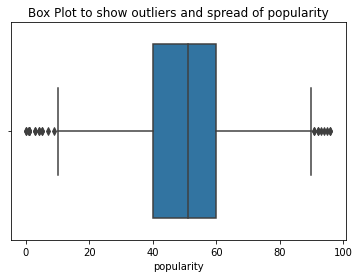

In [16]:
# Define Column of interest
col = 'popularity'

# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

From the box plot, `popularity` seems to be normal enough to remove outliers.

In [17]:
# Display observations that are considered outliers based on popularity
data[np.abs(zscore(data[col])) > 3]

,album_name,popularity,artist,song_name,duration_ms,explicit,release_date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
56,2.0,1,JLS,Audition,180666,False,2021-12-03,0.758,0.7810,-4.705,0.0491,0.00765,0.000000,0.0887,0.936,126.062
60,2.0,1,JLS,Feel Your Love,169373,False,2021-12-03,0.752,0.9330,-4.216,0.0375,0.05310,0.000506,0.1180,0.622,129.978
62,2.0,1,JLS,Tango,185226,False,2021-12-03,0.773,0.7880,-4.801,0.0636,0.02420,0.000000,0.1160,0.828,115.991
64,2.0,1,JLS,Glow,185173,False,2021-12-03,0.561,0.7500,-6.562,0.0699,0.01000,0.000000,0.1460,0.566,110.118
65,2.0,1,JLS,Eternal Love (Luca Schreiner Remix),187840,False,2021-12-03,0.466,0.7510,-5.558,0.1130,0.01140,0.000000,0.3020,0.650,79.798
380,Return of the Immigrant,1,Cashh,Terrible Operation Skit,23398,False,2021-11-05,0.549,0.5840,-13.476,0.6620,0.67600,0.000000,0.6420,0.522,95.616
383,Return of the Immigrant,0,Cashh,Look out Your Window Skit,21096,False,2021-11-05,0.490,0.0663,-30.056,0.0679,0.69000,0.626000,0.1090,0.309,88.505
386,Return of the Immigrant,1,Cashh,Mi G Dem Skit,24362,False,2021-11-05,0.368,0.0375,-31.712,0.1690,0.83300,0.000000,0.1970,0.696,126.926
567,The Lockdown Sessions,0,Elton John,One Of Me,161666,True,2021-10-22,0.708,0.5980,-4.969,0.0617,0.20200,0.000000,0.1690,0.561,144.096
688,Just for the Times,1,Everyone You Know,Human Again (Skit),17124,False,2021-10-01,0.411,0.6800,-12.463,0.3320,0.99500,0.027200,0.7500,0.724,126.006


These observations all have extremely low popularity (rated between 0-100). I don't believe these are errors however, they do not form the natural population of new releases that we are interested in as popularity is a key feature.

Decision: Remove these observations from dataset for analysis.

In [18]:
# Remove outliers
data = data[np.abs(zscore(data[col])) <= 3]

#### duration_ms

In [19]:
# Define Column of interest
col = 'duration_ms'

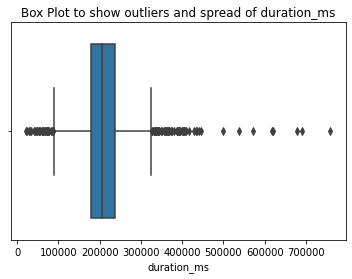

In [20]:
# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

`duration_ms` does seem to have some normal properties so it would be viable to remove outliers based on our Z-Scores.

In [21]:
# Display observations that are considered outliers based on duration_ms
data[np.abs(zscore(data[col])) > 3]

,album_name,popularity,artist,song_name,duration_ms,explicit,release_date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
122,Knebworth 1996 (Live),46,Oasis,"Champagne Supernova (Live at Knebworth, 11 Aug...",446246,False,2021-11-19,0.169,0.858,-5.128,0.0937,0.000107,0.220000,0.8490,0.2060,122.081
406,Day/Night,54,Parcels,Outside,433350,False,2021-11-05,0.352,0.166,-11.957,0.0312,0.813000,0.005600,0.1120,0.1140,105.264
641,Music Of The Spheres,68,Coldplay,Coloratura,617057,False,2021-10-15,0.285,0.265,-10.836,0.0288,0.629000,0.179000,0.0660,0.0699,134.055
940,What We Call Life,40,Jordan Rakei,The Flood,435146,False,2021-09-17,0.545,0.697,-7.529,0.0302,0.419000,0.026800,0.0991,0.3550,119.976
1124,Senjutsu,60,Iron Maiden,Senjutsu,500170,False,2021-09-03,0.347,0.885,-6.121,0.0615,0.000171,0.089200,0.2170,0.4660,180.172
1127,Senjutsu,58,Iron Maiden,Lost In A Lost World,571584,False,2021-09-03,0.251,0.871,-6.414,0.0871,0.004070,0.007510,0.1080,0.2060,92.975
1129,Senjutsu,57,Iron Maiden,The Time Machine,429443,False,2021-09-03,0.297,0.889,-5.287,0.0607,0.006540,0.000211,0.1180,0.3160,116.650
1130,Senjutsu,56,Iron Maiden,Darkest Hour,440464,False,2021-09-03,0.222,0.925,-5.939,0.2400,0.054200,0.086300,0.3950,0.1620,133.772
1131,Senjutsu,56,Iron Maiden,Death Of The Celts,620403,False,2021-09-03,0.291,0.804,-5.807,0.0414,0.007110,0.210000,0.1200,0.2600,134.561
1132,Senjutsu,56,Iron Maiden,The Parchment,758990,False,2021-09-03,0.149,0.924,-5.345,0.0933,0.014100,0.219000,0.1070,0.2120,80.234


There seems to be a pattern of an artist releasing one or two longer songs - with the exception of Iron Maiden who's entire album bar three songs were marked as outliers.

However, looking at the box plot, it seems as though capping at 446246 would be the most appropriate course of action as these seem to be more of the extreme values.

Decision: Cap values at 446246

In [22]:
# Remove observations above capping value
data = data[data.duration_ms <= 446246]

#### danceability

In [23]:
# Define Column of interest
col = 'danceability'

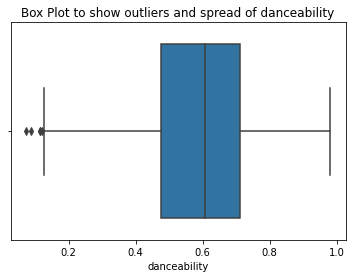

In [24]:
# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

This feature looks to have normal features - enough to use Z-Scores to determine outliers.

In [25]:
# Display observations that are considered outliers based on popularity
data[np.abs(zscore(data[col])) > 3]

,album_name,popularity,artist,song_name,duration_ms,explicit,release_date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
407,Day/Night,53,Parcels,SHADOW,181560,False,2021-11-05,0.0721,0.212,-12.492,0.0340,0.160,0.796,0.108,0.0351,178.482
633,Music Of The Spheres,66,Coldplay,✨,53033,False,2021-10-15,0.0859,0.289,-17.240,0.0359,0.805,0.990,0.141,0.0380,166.784


These observations do not seem to be errors, just abnormal realisations.

However, since the produced Z-Scores tell us these are abnormal and the box plot shows that it has a suitable shape to assume normality, we can remove these outliers.

Decision: Remove

In [26]:
data = data[np.abs(zscore(data[col])) <= 3]

#### loudness

In [27]:
# Define Column of interest
col = 'loudness'

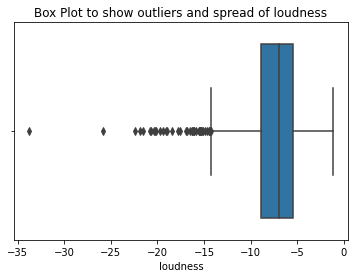

In [28]:
# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

The box plot suggests that a cap at -25 would be more appropriate to control outliers due to its non-normal box plot shape.

Decision: cap feature at -25

In [29]:
# Control outliers
data = data[data.loudness > -25]

In [30]:
# Define Column of interest
col = 'speechiness'

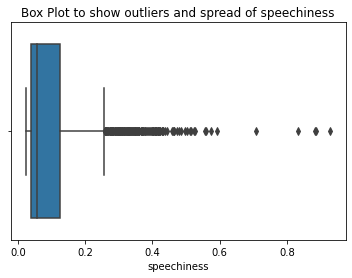

In [31]:
# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

The shape of this box plot suggests this feature is heavily not normal and that a capping approach would be more appropriate. The intention is to cap the last four values - we shall look at the data to find an appropriate cap.

In [32]:
np.sort(data.speechiness)[-5]

0.708

Decision: We shall cap at 0.708

In [33]:
# Cap speechiness
data = data[data.speechiness <= 0.708]

#### instrumentalness

In [34]:
# Define Column of interest
col = 'instrumentalness'

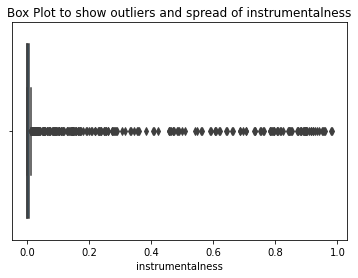

In [35]:
# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

Due to the skew shown in this box plot, we cannot use Z-Scores to evaluate outliers. It would seem highlighted observations are just down to the distribution of the feature.

### liveness

In [36]:
# Define Column of interest
col = 'liveness'

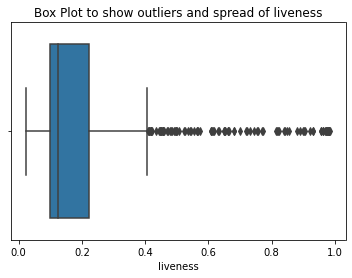

In [37]:
# Box plot to look at distribution and verify there is a somewhat normal distribution
sns.boxplot(data = data, x = col)
plt.title(f'Box Plot to show outliers and spread of {col}')
plt.show()

The box plot shown for `liveness` shows that its distribution cannot be assumed normal and so we will leave highlighted values as they are.

Decision: Leave feature as it is.


This is our last feature to check for outliers. We can now perform our analysis outlier-free.

# Step 3: Perform exploratory analysis and ask questions

Throughout this analysis, when using statistical tests, we use a threshold of 0.05 due to the Neyman-Pearson Lemma.

In [38]:
# Define plot colours
colours = 'bgrcyk' * 3

In [39]:
# Define lists of feature types
object_features = ['song_name', 'album_name', 'artist']

numerical_features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

bool_features = ['explicit']

date_features = ['release_date']

ignore_features = []

In [40]:
all_features = object_features + numerical_features + bool_features + date_features + ignore_features

print('All vars:', len(all_features))
print('data vars:', len(data.columns))

All vars: 16
data vars: 16


### Numerical Vars

In [61]:
numeric_df = data[numerical_features]

# Calculate summary metrics for each numerical feature
numeric_summary = numeric_df.describe().T

# Add additional metrics to summary
numeric_summary['Range'] = numeric_summary['max'] - numeric_summary['min']
numeric_summary['Median'] = numeric_df.median()
numeric_summary['Unique'] = numeric_df.nunique()
numeric_summary['Null'] = numeric_df.isnull().sum()

numeric_summary

,count,mean,std,min,25%,50%,75%,max,Range,Median,Unique,Null
popularity,1211.0,50.853014,15.255397,3.000000,41.0000,51.000000,60.000000,96.000,93.000000,51.000000,91,0
danceability,1211.0,0.590954,0.163972,0.113000,0.4780,0.606000,0.712000,0.981,0.868000,0.606000,559,0
energy,1211.0,0.614929,0.204160,0.047100,0.4750,0.634000,0.777000,0.987,0.939900,0.634000,600,0
loudness,1211.0,-7.468992,3.012801,-21.850000,-8.8850,-6.914000,-5.400000,-1.136,20.714000,-6.914000,1132,0
speechiness,1211.0,0.108500,0.112129,0.023400,0.0380,0.056900,0.124000,0.708,0.684600,0.056900,676,0
acousticness,1211.0,0.309948,0.312539,0.000004,0.0352,0.193000,0.555500,0.991,0.990996,0.193000,913,0
instrumentalness,1211.0,0.070746,0.202129,0.000000,0.0000,0.000037,0.004905,0.981,0.981000,0.000037,738,0
liveness,1211.0,0.194014,0.171303,0.023400,0.1010,0.125000,0.224000,0.985,0.961600,0.125000,543,0
valence,1211.0,0.448325,0.225417,0.018500,0.2605,0.434000,0.620000,0.967,0.948500,0.434000,662,0
tempo,1211.0,119.023580,28.893527,45.481000,95.6135,119.954000,139.468500,202.020,156.539000,119.954000,1183,0


### Distributions

In this next section we will be looking at the distributions of the numeric variables in our dataset and try to answer the following questions:
- Do any variables look to be normally distributed?
- Are there any notable levels of kurtosis and skewness?

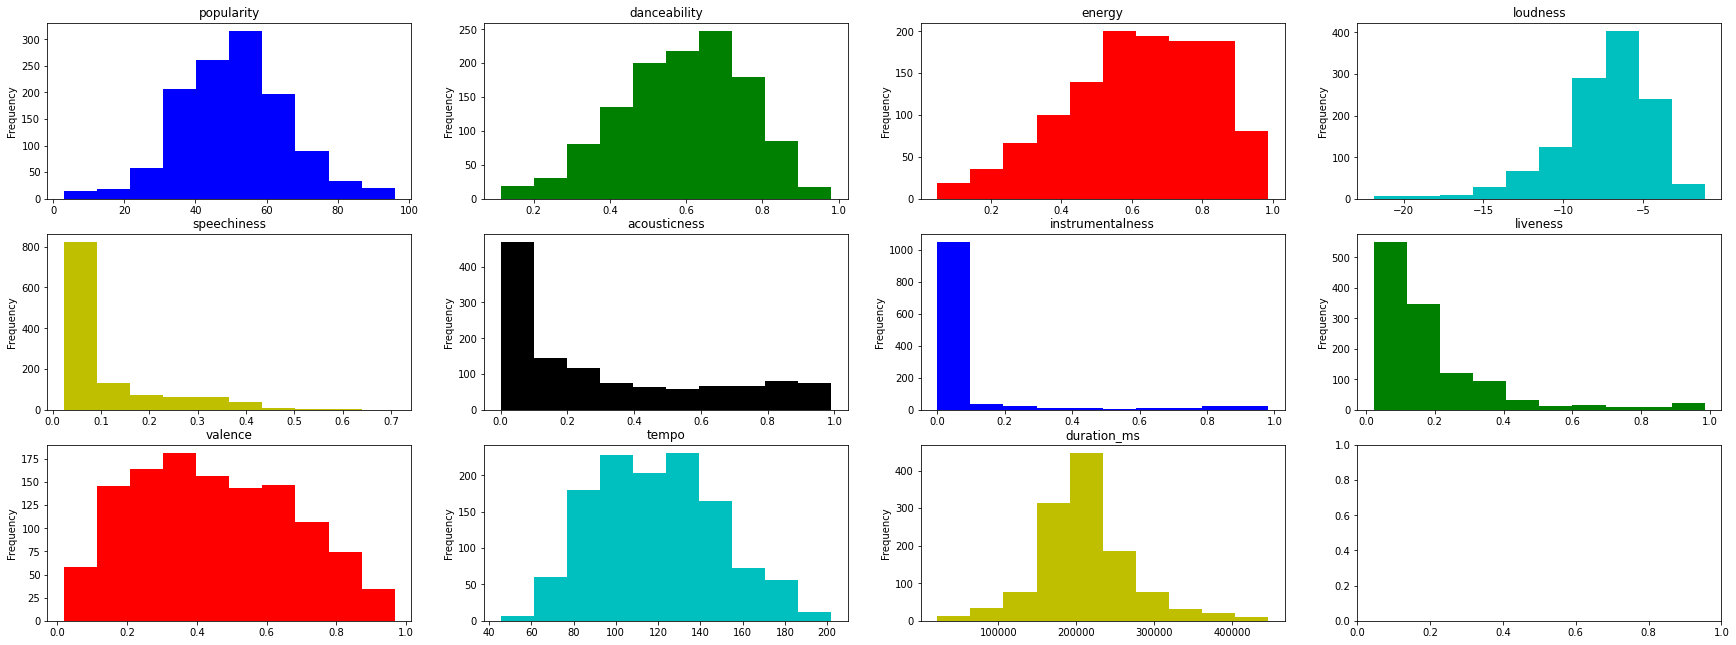

In [44]:
# Create subplots to display the plots nicely
fig, ax = plt.subplots(
    nrows = 3,
    ncols = 4,
    figsize = (30, numeric_df.shape[1])
)

# Loop through each numeric feature and plot a frequency histogram 
for idx, col in enumerate(numerical_features):

    # Use idx to generate coordinates
    x, y = idx // 4, idx % 4

    # Plot the histogram
    numeric_df[col].plot(
        ax = ax[x,y],
        kind = 'hist',
        color = colours[idx],
        legend = False,
        title = col
    )

plt.show()

#### Q1.1: Do any variables look to be normally distributed?

As we can see from the histograms, `popularity` and `duration_ms` are the only one that looks to have a histogram that resembles a normal distribution. Since these are arguably the most 'human' features, this would make sense. However, even between these two features, the kurtosis varies: `popularity` has a medium-levelled peak and `duration_ms` had a sharp peak suggesting it has more of a leptokurtic distribution.

Other variables are all skewed and have a different kurtosis. 

We can test if these features are normal more rigorously with a normality test:

In [62]:
# Perform normal test for each of the specified columns
for col in  ['popularity', 'duration_ms']:
    print(f'--- {col.upper()} ---')

    # Perform normal test for column in loop
    statistic, pvalue = normaltest(data[col])
    print(f"pvalue: {pvalue:g}")

    # Null Hypothesis: x comes from a normal distribution
    if pvalue < 0.05:
        print("Reject Null Hypothesis")
    else:
        print("Fail to Reject Null Hypothesis")

--- POPULARITY ---
pvalue: 0.0476644
Reject Null Hypothesis
--- DURATION_MS ---
pvalue: 2.30963e-24
Reject Null Hypothesis


We see that, although the histograms look normal, these features are unfortunately not normally distributed due to this normality test - however close to 0.05 the pvalue is.


#### Q1.2: Are there any notable levels of kurtosis and skewness?

The variables that stand out from these histograms in terms of skew and kurtosis are `Valence`, `Instrumentalness`/`Acousticness`/`Speechiness` and `Energy`.

`Valence` (the level of musical positivity conveyed by the track) stands out due to its lack of major skew, and low levels of kurtosis. This tells us that, although the mean is `0.454` and it does peak at this point, there is less of a difference in frequency between the extremities and the mean suggesting this variable is the most evenly spread.

`Instrumentalness`/`Acousticness`/`Speechiness` are all grouped together because they all show a similar distribution: a highly positive skew with an incredibly high kurtosis. This makes sense as these features tend to be more binary where a track has an emphasis on the music and the instruments or it otherwise focuses on the lyrics. Something to potentially consider for these factors in any future analysis is either to create a binary factor from them or disregard them in modelling if values greater than one are considered too rare.

`Energy` is also something that draws my eye because it has quite a large negative skew with low kurtosis. This suggests that songs with higher `energy` are currently being released - perhaps in preparation for Christmas positivity. The low kutosis, in a similar way to `valence`, suggests that this variable is also more evenly spread than other variables.

### Correlations

In this next section we will be looking at the correlations between numeric variables so that we can answer the following questions:

- Which features are strongly correlated?
- Is this expected?

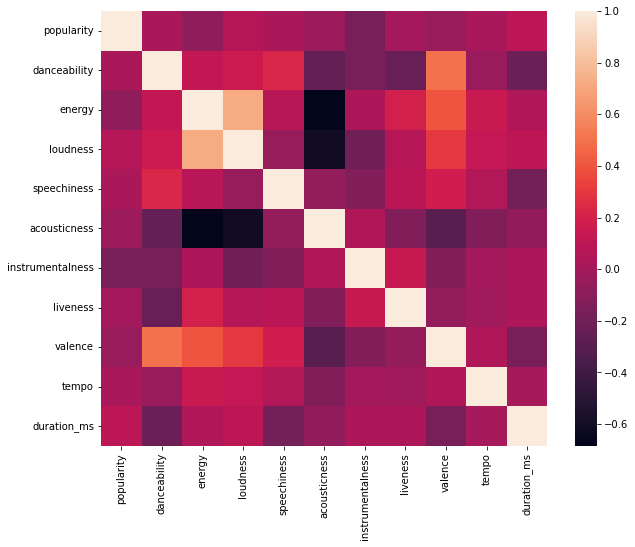

In [63]:
# Generate correlation value between all numeric features
corr = data[numerical_features].corr()

# Create subplot for display
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap for correlations
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax = ax)

plt.show()

In [47]:
highly_corr = []

# Loop through correlated values and create list of columns that are highly correlated
for i in corr.index:
    for j in corr.columns:

        # We define correlation values of 0.4 to be highly correlated
        if 0.4 < abs(corr).loc[i, j] < 1 and (j, i) not in highly_corr:
            highly_corr.append((i, j))

#### Q2.1: Which features are strongly correlated?

We can see that there are some stronger levels of correlation between the above features. We have chosen all pairs that exhibit and correlation score of over 0.4 in absolute value. This is because we are concerned with strongly correlated cases and pairs such as (`loudness`, `valence`) show some levels of correlation, but not what we are currently interested in.


We shall display scatter plots for each pair to give us a better understanding of their relationships.

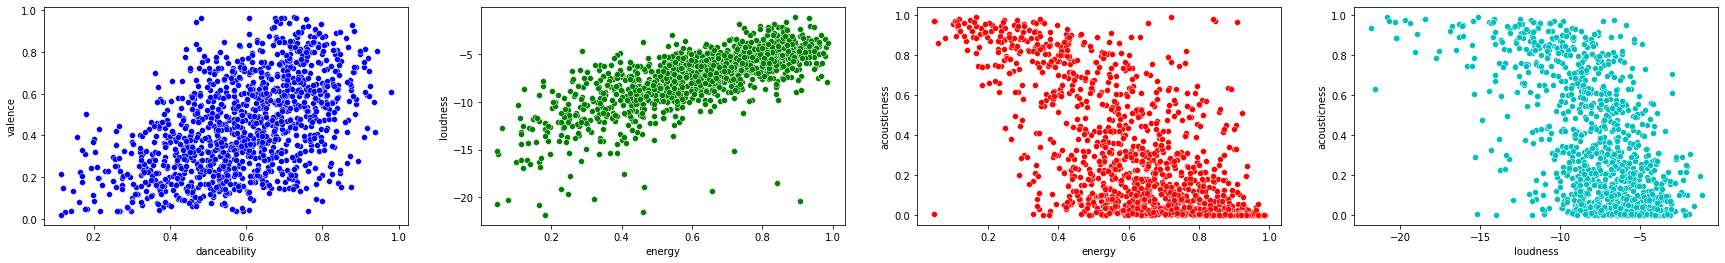

In [64]:
# Create subplots to display the plots nicely
fig, ax = plt.subplots(
    nrows = (len(highly_corr) // 4),
    ncols = 4,
    figsize = (30, len(highly_corr))

)

# Loop through each numeric feature and plot a frequency histogram 
for idx, pair in enumerate(highly_corr):

    # Plot the scatter plot for this loop
    sns.scatterplot(
        ax = ax[idx],
        data = data,
        x = pair[0],
        y = pair[1],
        color = colours[idx],
        ci = None
    )

plt.show()

#### Q2.2: What's interesting about the shape of these graphs?

Obviously, the plots match the correlation values, but what is interesting about these scatter graphs are the gradients of the hypothetical line of best fits. The (`energy`, `loudness`) relationship is clearly the strongest; however, the gradient is very shallow. This tells us that a small change in the loudness rating of a song has dramatic effects on its energy ratings. This is something we would want to consider in modelling.

What's interesting is that the correlation between `energy` and `loudness` seems to be transitive i.e. since `energy` $\propto$
 `acousticness` and `acousticness` $\propto$ `loudness` then the fact that `energy` and `loudness` are also correlated suggests these three factors have a cyclical, transitive relationship.

For further modelling, only one from `energy` and `loudness` should be included due to the high correlation.

### Regression Analysis: Energy vs. Loudness

#### Q2.3: Is the relationship between Energy and Loudness Linear?

To answer this question, we will perform linear regression to see if a linear model would sufficiently fit this relationship.

In [49]:
# Define X and y for our analysis
X, y = data['energy'].values.reshape(-1,1), data['loudness'].values

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [50]:
# Create and fit model
lrm = LinearRegression(fit_intercept=True)
lrm.fit(X_train, y_train)

# Score model
print(f'Model .score value, test data: {lrm.score(X_test, y_test):.5f}')

Model .score value, test data: 0.54587


Not the perfect model here, since 0.54587 is not close to 1.00. However, it is sufficient performance for our requirements.

In [59]:
# Print model intercept and gradient
print(f'LinearRegression Model Intercept: {lrm.intercept_}')
print(f'LinearRegression Model Gradient: {lrm.coef_[0]}')

LinearRegression Model Intercept: -13.749480832789684
LinearRegression Model Gradient: 10.2945167800307


Looking at our model gradient, we see a strong positive correlation of 10x between `energy` and `loudness`.

We will now produce a plot to view this model.

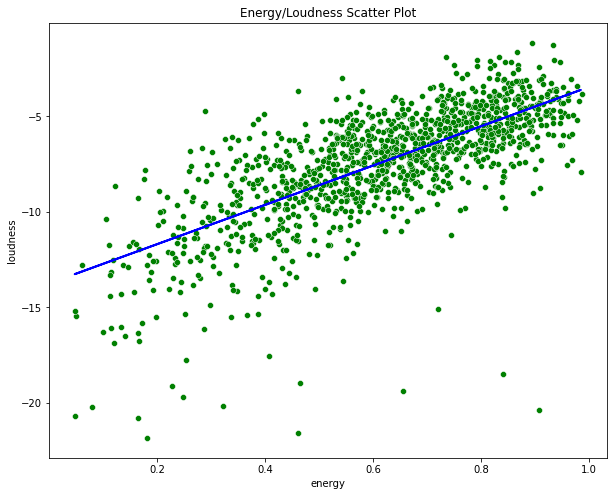

In [65]:
# Create subplots for display
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (10, 8)

)

# Generate predictions
y_pred = lrm.predict(X_test)

# Plot scatter plot
sns.scatterplot(ax = ax,
        data = data,
        x = 'energy',
        y = 'loudness',
        color = 'g',
        ci = None
    )

# Give plot a title
plt.title('Energy/Loudness Scatter Plot')

# Plot straight line of model predictions in blue
plt.plot(X_test, y_pred, color="blue", linewidth=2)

Plotting the predictions from the test set as a line on the scatter plot, we can see that it fits the bulk of the data reasonably well. This comment is supported by the $R^2$ value that we have for this model.

However, the intuition does suggest that the relationship is potentially not linear - particularly as energy moves towards 0. These points will have been removed in our outlier analysis as it's not the body of data we are interested in.

Regression suggests that there is at least a linear relationship not near the extremities.


### Bool Variables - Explicit

In [393]:
bool_df = data[bool_features]

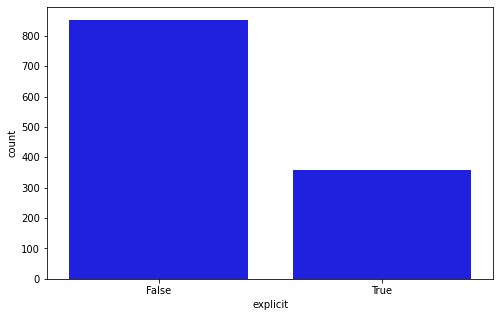

In [394]:
# Create subplot for display
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (8, 5)

)

# Plot count plot of explicit variable
sns.countplot(
    data = bool_df,
    x = 'explicit',
    color = colours[0]
)

plt.show()

We can see that there is a slight difference between the value counts of the True and False values. There are roughly double the number of False values compared to True, but this should not affect the results too much.

### Boolean Correlation with Numeric Feaetures

### Explicit Feature

In this section we will be looking at the effect of the explicit feature on our numeric features. We will be looking to answer the following questions:

- How does the explicit score of a song affect the audio feature scores?
- Does any single audio feature jump out?
- Assuming this is the case, does this relationship make sense?

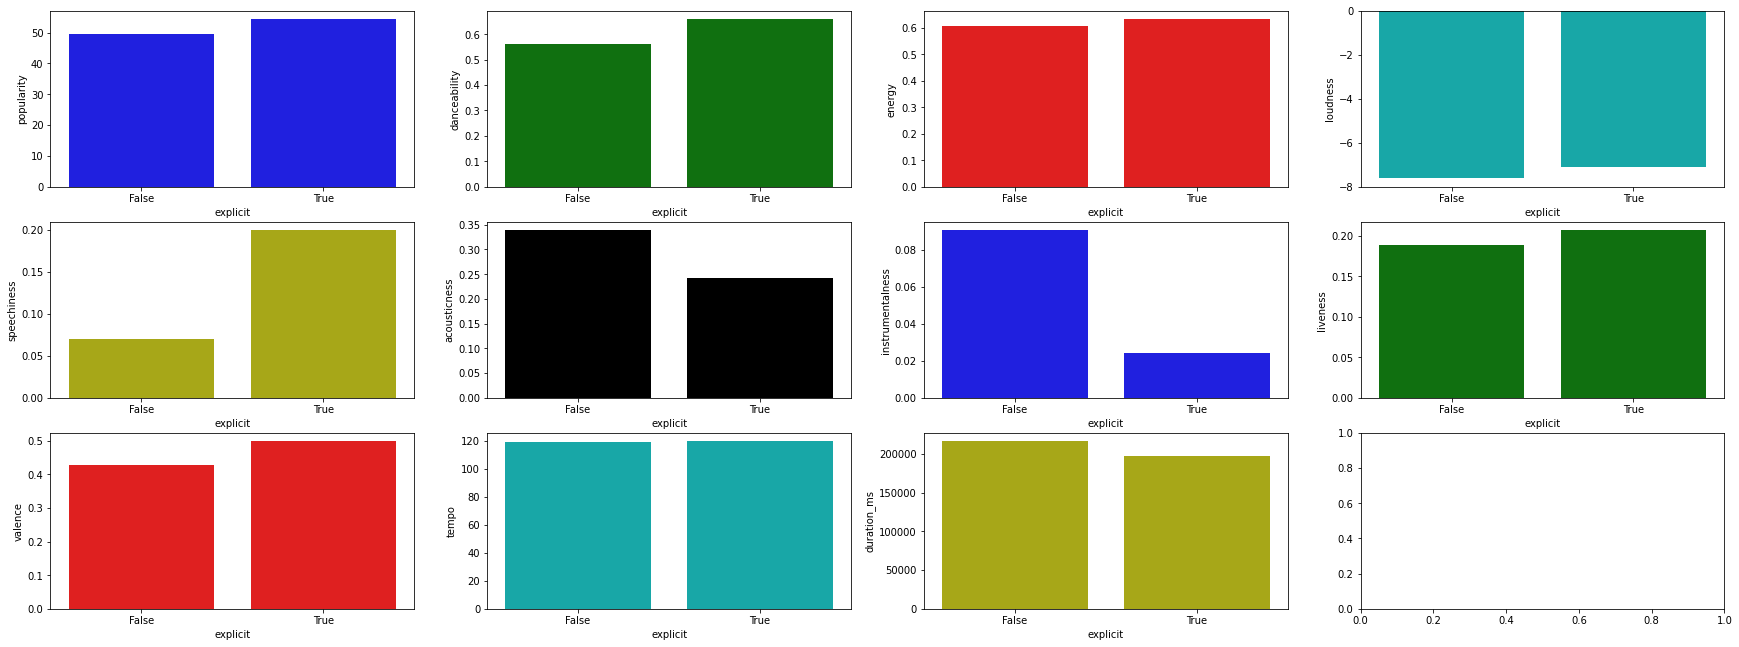

In [66]:
# Create subplots for display
fig, ax = plt.subplots(
    nrows = 3,
    ncols = 4,
    figsize = (30, numeric_df.shape[1])
)

# Loop through numerical features and plot frequencies under the explicit varible
for idx, ncol in enumerate(numerical_features):

    # Use index as coordinate systems
    x, y = idx // 4, idx % 4

    # Plot bar chart for relationship
    sns.barplot(
        ax = ax[x, y],
        data = data,
        x = 'explicit',
        y = ncol,
        color = colours[idx],
        ci = None
    )

plt.show()

#### Q3.1: How does the explicit score of a song affect the audio feature scores?

- It does look like a track being `explicit` does affect some audio features.
- There is a slight difference in popularity based on whether a song is `explicit` or not. We can see that the `explicit` songs in our data have a higher average `popularity` score. Although the frequency of explicit tracks is half that of non-explicit tracks and that this difference is small, this is something that we will look deeper into with a hypothesis test.
- Features to be more so affected are `speechiness`, `acousticness` and `instrumentalness` which has a massive gulf between the average score of this boolean. 
- We also see that the `danceability` of a track is affected by if it is `explicit` or not.

#### Q3.2: Does any single audio feature jump out? And do these relationships make sense?

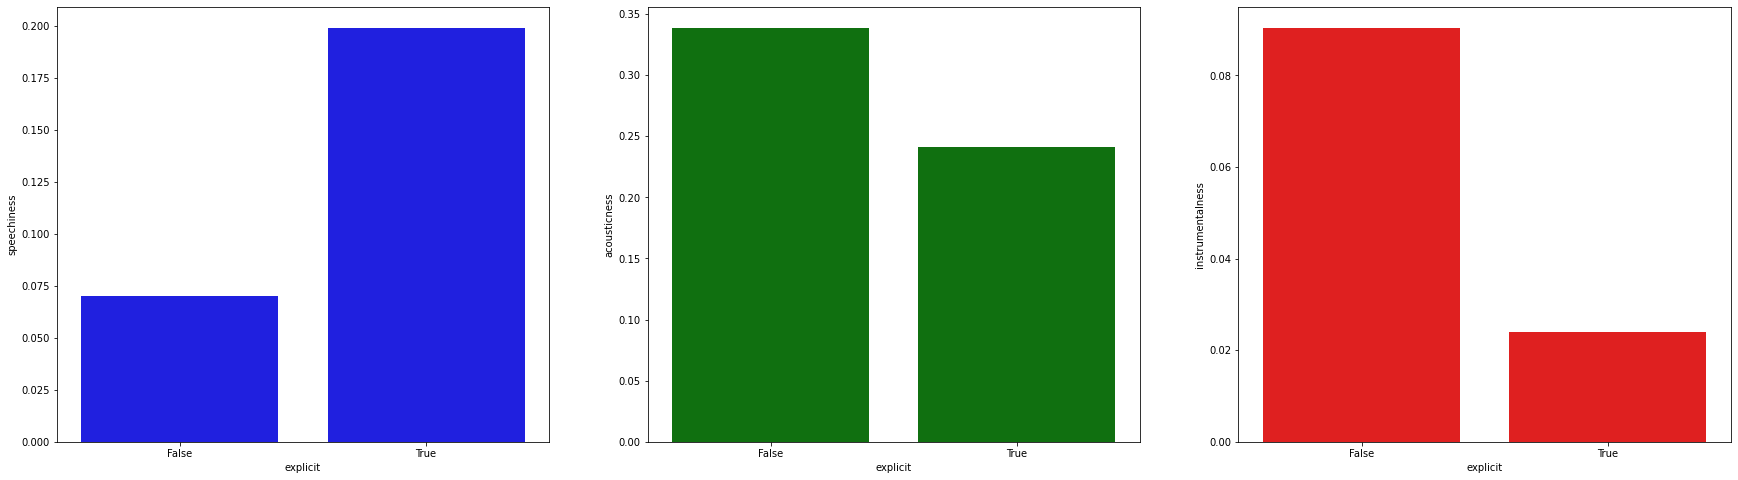

In [396]:
# Specify columns that jump out
columns_of_interest = ['speechiness', 'acousticness', 'instrumentalness']

# Create subplots for plot display
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (30, 8)
)

# Loop through columns of interest to create bar plots
for idx, ncol in enumerate(columns_of_interest):

    # Create bar plots
    sns.barplot(
        ax = ax[idx],
        data = data,
        x = 'explicit',
        y = ncol,
        color = colours[idx],
        ci = None
    )

plt.show()

- The following features jump out: `speechiness`, `acousticness` and `instrumentalness`.
- The `acousticness` and `instrumentalness` relationships jump out because of the extreme difference. However, these relationships are intuitive because songs that have a high score for `acousticness` and `instrumentalness` conversely have a lack in lyrics because the emphasis is not there, and so the averages are so much higher for non-explicit tracks.
- The `speechiness` relationship also makes sense for a similar reason as above but in the opposite direction. This suggests that if a song has more words or greater clarity of lyrics, it is more likely that an explicit word appears in the song.


### Hypothesis Tests

#### Q3.3: Is there a significant statistical difference in `danceability`, `popularity` and `liveness` when a song is Explicit or not?

The two features that look to have a more subtle difference are `danceability`, `popularity` and `liveness`.

Does `danceability`, `popularity` and `liveness` vary based on if a song is explicit or not?

Null Hypothesis: $\mu_{True} - \mu_{False} = 0$

Alternative Hypothesis: $\mu_{True} - \mu_{False} \neq 0$

In [60]:
# Perform the following hypothesis tests for the specified columns
for var in ['popularity', 'danceability', 'liveness']:
    print('\n---', var.upper(), '---')

    # Split data based on explicit variable
    data_explicit_true = data[data.explicit == True][var]
    data_explicit_false = data[data.explicit == False][var]

    print('Variances:')
    # Check for variance difference
    var_true = np.var(data_explicit_true)
    var_false = np.var(data_explicit_false)
    print(f'\tTrue: {var_true}\n\tFalse: {var_false}')

    # Make sure the variance ratios are suitable
    if 0.25 < var_true/var_false < 4:
        print(f'There is a suitable ratio in variances for us to perform this hypothesis test.')

        #Perform test
        print('\nHypothesis test:')
        statistic, pvalue = ttest_ind(data_explicit_true, data_explicit_false)

        # Print results
        print(f'\tstatistic: {statistic:.5f}')
        print(f'\tpvalue: {pvalue:.5f}')
    else:
        print('Ratio between variance is too large. Test not performed.')


--- POPULARITY ---
Variances:
	True: 240.36356018342502
	False: 222.02447017787475
There is a suitable ratio in variances for us to perform this hypothesis test.

Hypothesis test:
	statistic: 5.19314
	pvalue: 0.00000

--- DANCEABILITY ---
Variances:
	True: 0.026416052156640626
	False: 0.024262203435991534
There is a suitable ratio in variances for us to perform this hypothesis test.

Hypothesis test:
	statistic: 9.76510
	pvalue: 0.00000

--- LIVENESS ---
Variances:
	True: 0.033880635425547596
	False: 0.02730039542005554
There is a suitable ratio in variances for us to perform this hypothesis test.

Hypothesis test:
	statistic: 1.69195
	pvalue: 0.09091


Since our pvalue is less that 0.05 in the first two cases, we find a statistically significant difference between the two means and reject the null hypothesis for `danceability` and `popularity`.

However, we do not have sufficient evidence to reject the null hypothesis for `liveness` and so we fail to reject that $\mu_{True} - \mu_{False} = 0$

This means we can answer our question and say that there $\it{is}$ a difference in `popularity` and `danceability` based on if a song is explicit or not, but we fail to reject for the case of `liveness`.

Informally, our bar charts suggest that these statistically significant differences tell us that explicit songs tend to be $\it{more}$ popular than not explicit songs. Also, it tells us that explicit songs tend to have higher `danceability` scores.

## Step 4: Summarise and write a conclusion using markdown cells

#### What we have learnt from our analysis:

- We started by looking at the distributions of the numeric features using histograms. What jumped out was that `popularity` and `duration_ms` seemed to follow normal distributions; however, a normality test showed us that these features are not normally distributed.

- These histograms also showed us that Instrumentalness/Acousticness/Speechiness all have distinctive distributions. All three factors showed a highly positive skew with an incredibly high kurtosis. In other terms, we saw a sharp peak at 0 with a very low frequency of values above 0. These extreme structures painted pictures that these features could almost be treated as binary in further modelling.

- We then moved on to look at correlation coefficients between the data's numeric features to see if we could identify any highly correlated features. We found that there to be a strong correlation between `energy` and `loudness` such that more energetic songs tend to be louder. We performed further analysis using a scatter plot to visually see their relationship. The plot suggested linear regression would be an appropriate route to take. This modelling technique seemed to describe the relationship relatively well, but highlighted the fact that the relationship may not necessarily be linear and could have some logarithmic component. After enacting a logarithmic transformation and performing the modelling analysis again, we found that this did not improve the model score so concluded that the linear model was sufficient.

- Finally, we looked at the impact a song being explicit had on our audio features. We found that there seemed to be large effects on `speechiness`, `acousticness` and `instrumentalness` and more granular changes to `popularity` and `danceability`. Since the impact was less obvious for `popularity` and `danceability`, it was appropriate to perform a hypothesis test on whether there was a difference in the mean of `popularity`/`danceability` when the song is explicit and the mean when it was not. These hypothesis tests concluded that there was a statistically significant difference between the two means in both cases. This told us that a song being explicit *does* have an effect on a song's `popularity` and `danceability` ratings.

#### Future Work

- These trends work for recent new releases. Do they hold for a general sample?
> Since the sample of data we have taken is from the albums of the 100 most recent releases, there is a possible time dependence on the trends we have found. In terms of future work, this would be an interesting idea to explore, to answer the question of if we see changes to the conclusions we have made if we take a general sample/larger sample etc. This would be interesting because the current analysis would be useful to model new releases and what we could expect future releases to look like; whereas, a general sample would be useful to model the structure of a generic song sampled from the Spotify database.

- Further, have these trends changed over time?
> Another angle that would be very interesting to explore would be to consider if these conclusions have changed over time. To answer the question of if there is a change decade to decade and, if so, what rate this change occurs on - do we see a change if we take yearly samples? Monthly? Weekly? We would do this by taking random samples from different decades to break correlations across other factors.
> This would be useful because our analysis is useful in terms of analysing how we might expect the metrics of new releases to look. However, the next step of seeing this change through time would elevate the usefulness of this work as it can be adaptive to the future.